In [73]:
import pandas
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

In [2]:
usd_rate = pandas.read_excel("usd_rate.xlsx")
curs = usd_rate.curs
future = 7 # Попытаемся предсказать курс на 7 дней вперед
past = 14 # На основе 14 дней в прошлом
start = past
end = len(curs) - future

In [3]:
raw_df = [list(curs[(day-past):(day+future)]) for day in range(start, end)]

In [4]:
past_columns = [f"past_{i}" for i in range(past)]
past_columns

['past_0',
 'past_1',
 'past_2',
 'past_3',
 'past_4',
 'past_5',
 'past_6',
 'past_7',
 'past_8',
 'past_9',
 'past_10',
 'past_11',
 'past_12',
 'past_13']

In [5]:
future_columns = [f"future_{i}" for i in range(future)]
future_columns

['future_0',
 'future_1',
 'future_2',
 'future_3',
 'future_4',
 'future_5',
 'future_6']

In [6]:
total_columns = past_columns + future_columns
df = pandas.DataFrame(data=raw_df, columns=total_columns)

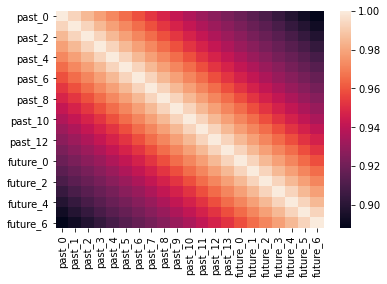

In [7]:
# для анализа надежности и доверительности модели следует проверить уровень корреляции между составляющими датасета.
# С учетом того, что автомасштабирование коэффициентов корреляции находитcz в пределах 1 - 0.9, то это означает, что корреляция достатолчно высокая корреляция между величинами
# Как правило из модели features с большой корреляцией между собой надо убирать - 
# соответственно надежность прогнозов при такой высокой корреляции будет крайне низкой
sns.heatmap(df.corr())

In [8]:
# Обучающая выборка (тренировочная) "Учебник"
X = df[past_columns][:-1]
Y = df[future_columns][:-1]

In [9]:
# Проверочная (тестовая) выборка, "Экзамен"
X_test = df[past_columns][-1:]
Y_test = df[future_columns][-1:]

In [ ]:
lr = LinearRegression() # Настройки
lr.fit(X,Y) # Обучение
prediction = lr.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction")
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mean_absolute_error(prediction[0], Y_test.iloc[0])

In [ ]:
KNN = KNeighborsRegressor(n_neighbors=2)
KNN.fit(X,Y)
prediction = KNN.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

In [ ]:
# Использовать датасет из эфира (будет выложен в ТГ)
# Использовать random_state=42
# 1. Документция по Sklearn https://scikit-learn.org/stable/modules/classes.html
# 2. Подобрать параметры MLPRegressor, добиться MAE (mean_absolute_error) меньше чем в эфире 0.924
# 3. Выбрать из sklearn 4 (четыре) других модели регресии 
# (...Regressor, модели которые мы еще НЕ испольовали), 
# и добиться на них наименьшей ошибки. 

# Критерием оценки ДЗ НЕ ЯВЛЯЕТСЯ самая минимальная ошибки.
# 4. Оформить свой результат в виде HTML файла (Меню File -> Download as -> HTML), 
# в файле должно быть
# — Комментарии к коду, что вы делаете в этом коде и зачем
# — Графики (https://matplotlib.org/gallery/index.html)
# — В отчете должны быть выводы

# Дз нужно прислать до 18:00 МСК завтра(ВС), что бы мы успели все проверить
# Ссылка куда прислать будет в ТГ

In [10]:
mlpr = MLPRegressor(random_state=42)

fitting time - 181 seconds
Best: 0.593266 using {'activation': 'relu', 'hidden_layer_sizes': (270, 270), 'max_iter': 200, 'solver': 'adam'}
-12.100657 (9.356956) with: {'activation': 'tanh', 'hidden_layer_sizes': (200, 200), 'max_iter': 100, 'solver': 'sgd'}
-87.014663 (81.940247) with: {'activation': 'tanh', 'hidden_layer_sizes': (200, 200), 'max_iter': 100, 'solver': 'adam'}
-12.100657 (9.356956) with: {'activation': 'tanh', 'hidden_layer_sizes': (200, 200), 'max_iter': 200, 'solver': 'sgd'}
-11.110267 (7.756278) with: {'activation': 'tanh', 'hidden_layer_sizes': (200, 200), 'max_iter': 200, 'solver': 'adam'}
-12.065151 (9.389479) with: {'activation': 'tanh', 'hidden_layer_sizes': (210, 210), 'max_iter': 100, 'solver': 'sgd'}
-69.200845 (69.073116) with: {'activation': 'tanh', 'hidden_layer_sizes': (210, 210), 'max_iter': 100, 'solver': 'adam'}
-12.065151 (9.389479) with: {'activation': 'tanh', 'hidden_layer_sizes': (210, 210), 'max_iter': 200, 'solver': 'sgd'}
-11.172743 (7.607641) 

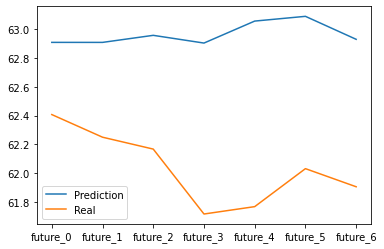

In [12]:
# как правило очень большое влияние в моделях на основе нейростей играют 
# - функции активации 
# - оптимизаторы (solver)
# - конфигурация скрытых слоёв
# - количество итераций для оптимизатора для достижения сходимости 
# (как правило, если модель не сходится быстро, то выбирать слишком большое число max_iter смысла нет)
params = dict(
    activation= ["tanh", "relu"],
    hidden_layer_sizes= [(x, x) for x in range(200, 301, 10)],
    max_iter= [100, 200],
    solver= ["sgd", "adam"]
)

# с помощью автоматизированного поиска найдем оптимальную конфигурацию для предиктора
grid = GridSearchCV(estimator=mlpr, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
# сделаем поиск оптимальной комбинации без вывода warning сообщений 
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X, Y)

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

In [13]:
bagging_regressor = BaggingRegressor(random_state=42)

fitting time - 2 seconds
Best: -1.114529 using {'n_estimators': 6}
-2.496228 (2.616552) with: {'n_estimators': 1}
-1.606326 (1.792405) with: {'n_estimators': 2}
-1.610025 (1.889809) with: {'n_estimators': 3}
-1.263998 (1.945930) with: {'n_estimators': 4}
-1.247677 (1.985253) with: {'n_estimators': 5}
-1.114529 (2.010378) with: {'n_estimators': 6}
-1.133226 (1.946138) with: {'n_estimators': 7}
-1.163463 (1.974070) with: {'n_estimators': 8}
-1.158395 (1.905788) with: {'n_estimators': 9}
-1.213643 (1.916373) with: {'n_estimators': 10}
-1.221383 (1.913569) with: {'n_estimators': 11}
-1.222537 (1.918916) with: {'n_estimators': 12}
-1.246034 (1.916825) with: {'n_estimators': 13}
-1.289861 (1.941150) with: {'n_estimators': 14}
-1.264073 (1.889933) with: {'n_estimators': 15}
-1.265044 (1.867415) with: {'n_estimators': 16}
-1.272611 (1.865908) with: {'n_estimators': 17}
-1.315660 (1.896738) with: {'n_estimators': 18}
-1.283364 (1.844521) with: {'n_estimators': 19}
MAE = 0.8791904761904722


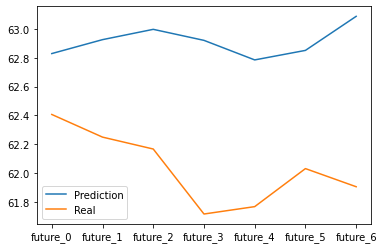

In [14]:
# попробуем оптимизировать количество эстиматоров 
params = dict(
    n_estimators=[x for x in range(1,20)]
)

# с помощью автоматизированного поиска найдем оптимальную конфигурацию для предиктора
grid = GridSearchCV(estimator=bagging_regressor, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X, Y)

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

In [15]:
rf_regressor = RandomForestRegressor(random_state=42)

fitting time - 2 seconds
Best: -1.057982 using {'n_estimators': 6}
-2.470393 (2.613582) with: {'n_estimators': 1}
-1.557881 (1.747415) with: {'n_estimators': 2}
-1.352147 (1.760845) with: {'n_estimators': 3}
-1.070908 (1.825430) with: {'n_estimators': 4}
-1.125626 (1.894833) with: {'n_estimators': 5}
-1.057982 (1.998455) with: {'n_estimators': 6}
-1.095672 (1.964332) with: {'n_estimators': 7}
-1.106696 (1.979729) with: {'n_estimators': 8}
-1.116797 (1.909194) with: {'n_estimators': 9}
-1.194881 (1.940639) with: {'n_estimators': 10}
-1.194230 (1.924535) with: {'n_estimators': 11}
-1.172882 (1.899376) with: {'n_estimators': 12}
-1.204324 (1.895522) with: {'n_estimators': 13}
-1.265280 (1.940696) with: {'n_estimators': 14}
-1.285400 (1.934674) with: {'n_estimators': 15}
-1.297218 (1.931351) with: {'n_estimators': 16}
-1.346628 (1.972181) with: {'n_estimators': 17}
-1.359776 (1.965015) with: {'n_estimators': 18}
-1.316241 (1.884463) with: {'n_estimators': 19}
MAE = 0.9117833333333313


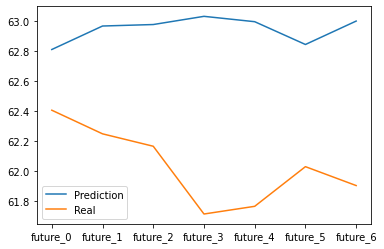

In [16]:
# попробуем оптимизировать количество эстиматоров 
params = dict(
    n_estimators=[x for x in range(1,20)]
)

# с помощью автоматизированного поиска найдем оптимальную конфигурацию для предиктора
grid = GridSearchCV(estimator=rf_regressor, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X, Y)

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

In [54]:
extra_trees_regressor = ExtraTreesRegressor(random_state=42)

fitting time - 13 seconds
Best: -1.178697 using {'n_estimators': 125}
-1.460809 (1.746832) with: {'n_estimators': 5}
-1.294132 (1.912877) with: {'n_estimators': 10}
-1.366318 (1.999220) with: {'n_estimators': 15}
-1.307557 (2.049701) with: {'n_estimators': 20}
-1.338080 (2.135822) with: {'n_estimators': 25}
-1.290736 (2.118066) with: {'n_estimators': 30}
-1.314983 (2.105184) with: {'n_estimators': 35}
-1.338666 (2.094773) with: {'n_estimators': 40}
-1.291005 (2.030668) with: {'n_estimators': 45}
-1.303021 (2.034841) with: {'n_estimators': 50}
-1.326407 (2.049746) with: {'n_estimators': 55}
-1.347128 (2.043566) with: {'n_estimators': 60}
-1.263639 (1.912949) with: {'n_estimators': 65}
-1.267807 (1.935731) with: {'n_estimators': 70}
-1.225323 (1.949655) with: {'n_estimators': 75}
-1.210740 (1.961837) with: {'n_estimators': 80}
-1.188721 (1.966795) with: {'n_estimators': 85}
-1.202724 (1.952537) with: {'n_estimators': 90}
-1.227773 (1.960458) with: {'n_estimators': 95}
-1.235637 (1.959194

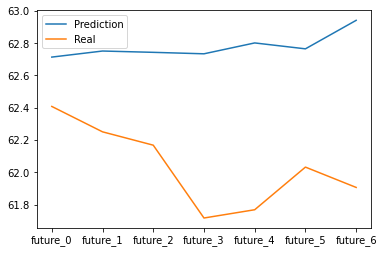

In [55]:
# попробуем оптимизировать количество эстиматоров 
params = dict(
    n_estimators=[x for x in range(5,151, 5)]
)

# с помощью автоматизированного поиска найдем оптимальную конфигурацию для предиктора
grid = GridSearchCV(estimator=extra_trees_regressor, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X.to_numpy(), Y.to_numpy())

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction[0], Y_test.iloc[0])
print(f"MAE = {mae}")

In [60]:
# Для того чтобы использовать GradientBoosting и, к примеру, AdaBoost следует использовать future a размере 1 значения
future = 1 # Попытаемся предсказать курс на 7 дней вперед
past = 14 # На основе 14 дней в прошлом

raw_df_upd = [list(curs[(day-past):(day+future)]) for day in range(start, end)]

past_columns = [f"past_{i}" for i in range(past)]
future_columns = [f"future_{i}" for i in range(future)]

total_columns = past_columns + future_columns
df_upd = pandas.DataFrame(data=raw_df_upd, columns=total_columns)

# Обучающая выборка (тренировочная) "Учебник"
X_upd = df_upd[past_columns][:-1]
Y_upd = df_upd[future_columns][:-1]

# Проверочная (тестовая) выборка, "Экзамен"
X_test_upd = df_upd[past_columns][-1:]
Y_test_upd = df_upd[future_columns][-1:]

In [74]:
ab_regressor = AdaBoostRegressor(random_state=42)

fitting time - 8 seconds
Best: -0.224530 using {'n_estimators': 45}
-0.299462 (1.034465) with: {'n_estimators': 5}
-0.255785 (0.964944) with: {'n_estimators': 10}
-0.253316 (1.059492) with: {'n_estimators': 15}
-0.226960 (1.005020) with: {'n_estimators': 20}
-0.270738 (1.036548) with: {'n_estimators': 25}
-0.260075 (1.063089) with: {'n_estimators': 30}
-0.286632 (1.081778) with: {'n_estimators': 35}
-0.266834 (1.042467) with: {'n_estimators': 40}
-0.224530 (0.992217) with: {'n_estimators': 45}
-0.251618 (1.025135) with: {'n_estimators': 50}
-0.271731 (1.048197) with: {'n_estimators': 55}
-0.275592 (1.055330) with: {'n_estimators': 60}
-0.295791 (1.079249) with: {'n_estimators': 65}
-0.273404 (1.063638) with: {'n_estimators': 70}
-0.254046 (1.041973) with: {'n_estimators': 75}
-0.266359 (1.040171) with: {'n_estimators': 80}
-0.282726 (1.062968) with: {'n_estimators': 85}
-0.314099 (1.061052) with: {'n_estimators': 90}
-0.289331 (1.062307) with: {'n_estimators': 95}
-0.265344 (1.036478) 

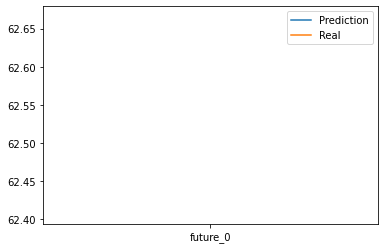

In [77]:
# попробуем оптимизировать количество эстиматоров 
params = dict(
    n_estimators=[x for x in range(5,151, 5)]
)

# с помощью автоматизированного поиска найдем оптимальную конфигурацию для предиктора
grid = GridSearchCV(estimator=ab_regressor, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X_upd, Y_upd)

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test_upd) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test_upd.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction, Y_test_upd.iloc[0])
print(f"MAE = {mae}")

In [78]:
gb_regressor = GradientBoostingRegressor(random_state=42)

fitting time - 10 seconds
Best: 0.310792 using {'n_estimators': 55}
-4.487691 (4.251389) with: {'n_estimators': 5}
-1.614528 (2.314097) with: {'n_estimators': 10}
-0.497840 (1.566208) with: {'n_estimators': 15}
-0.076708 (1.255195) with: {'n_estimators': 20}
0.103293 (1.096312) with: {'n_estimators': 25}
0.194215 (0.988708) with: {'n_estimators': 30}
0.249384 (0.912401) with: {'n_estimators': 35}
0.293691 (0.845768) with: {'n_estimators': 40}
0.301925 (0.828222) with: {'n_estimators': 45}
0.309227 (0.816392) with: {'n_estimators': 50}
0.310792 (0.814134) with: {'n_estimators': 55}
0.309674 (0.816351) with: {'n_estimators': 60}
0.309808 (0.815860) with: {'n_estimators': 65}
0.310122 (0.814886) with: {'n_estimators': 70}
0.309823 (0.814730) with: {'n_estimators': 75}
0.310379 (0.814129) with: {'n_estimators': 80}
0.310236 (0.814430) with: {'n_estimators': 85}
0.301266 (0.826656) with: {'n_estimators': 90}
0.302486 (0.824395) with: {'n_estimators': 95}
0.302216 (0.825077) with: {'n_estima

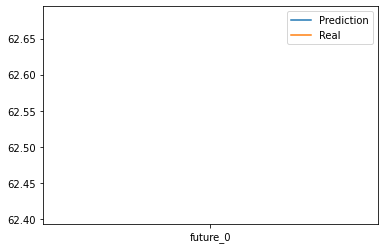

In [79]:
# попробуем оптимизировать количество эстиматоров 
params = dict(
    n_estimators=[x for x in range(5,151, 5)]
)

# с помощью автоматизированного поиска найдем оптимальную конфигурацию для предиктора
grid = GridSearchCV(estimator=gb_regressor, param_grid=params, cv=3, verbose=0)
# посмотреть на время, которое потребуется для поиска оптимальных параметров
d1 = datetime.now()
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    grid_result = grid.fit(X_upd, Y_upd)

d2 = datetime.now()
delta = d2 - d1
print("fitting time - {} seconds".format(delta.seconds))

# вывод наиболее удачной комбинации параметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
prediction = grid_result.predict(X_test_upd) # Предсказания
plt.plot(prediction[0], label="Prediction") # График
plt.plot(Y_test_upd.iloc[0], label="Real")
plt.legend()
mae = mean_absolute_error(prediction, Y_test_upd.iloc[0])
print(f"MAE = {mae}")

In [ ]:
Выводы: 
    1) В целом исходя из корреляционного анализа модель на основе данного датасета не будет слишком надежной
    2) Для поиска оптимальных показателей для нейросетевого регрессора можно использовать подход бинарного поиска - 
    то есть использовать параметры конфигурации слоев с грубым шагом (скажем 50), а затем постепенно уменьшать шаг, попутно уменьшая диапазон в range()
    3) Для подбора параметров в других регрессорах использовался, в основном, параметр, ответственный за количество эстиматоров (n_estimators)
    4) Для того, чтобы улучшить качество модели следует добавить в модель другие параметры (features):
        - которые представляют нелинейную комбинацию имеющихся параметров (в данном случае, к примеру, какие-то технические индикаторы на основе скользящих средних)
        - которые имеют косвенное отношение, то есть нескоррелированы с исходными данными, к примеру, упоминавшиеся цены на золото/нефть
        - применять оконные функции на добавленных параметрах (впрочем скользящая средняя и есть оконная функция) - 
        к примеру, добавить для холота и нефти добавить также скользящие средние. Эти показатели можно потом нормировать.
    5) В данной модели функции были гладкие, непрерывные - поэтому outlier detection не требовалось, хотя этот аспект может очень сильно влиять на качество модели.    
    6) Достаточно неплохие показатели получились от GradientBoosting и AdaBoost регрессоров. 
    Тем не менее, для них пришлось несколько изменить датасет, что само собой вносит соответствующие риски и ограничения.